# Setup workspace

In [ ]:
pip install -r requirements.txt

In [1]:
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential
from azure.ai.ml import MLClient

try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    credential = InteractiveBrowserCredential()

In [2]:
# Get a handle to workspace
ml_client = MLClient.from_config(credential=credential)

Found the config file in: /config.json


# Import data

In [3]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# load the dataset
print("Loading Data...")
df = pd.read_csv('data/breast-cancer.data')

Loading Data...


In [4]:
df

,recurence,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
...,...,...,...,...,...,...,...,...,...,...
281,recurrence-events,30-39,premeno,30-34,0-2,no,2,left,left_up,no
282,recurrence-events,30-39,premeno,20-24,0-2,no,3,left,left_up,yes
283,recurrence-events,60-69,ge40,20-24,0-2,no,1,right,left_up,no
284,recurrence-events,40-49,ge40,30-34,3-5,no,3,left,left_low,no


# Create a data asset

We create a data card to be used by our training pipeline

In [5]:
from azure.ai.ml.entities import Data

# Create a Data asset
data_asset = Data(
    path="data/breast-cancer.data",
    type="uri_file",
    name="cancer-data",
    description="Cancer data CSV file"
)

# Upload the data asset
ml_client.data.create_or_update(data_asset)

Data({'path': 'azureml://subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourcegroups/breast_cancer/workspaces/mlw-breast_cancer/datastores/workspaceblobstore/paths/LocalUpload/3e28c2b024c43e7f9d7b04e56af90b9e/breast-cancer.data', 'skip_validation': False, 'mltable_schema_url': None, 'referenced_uris': None, 'type': 'uri_file', 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'cancer-data', 'description': 'Cancer data CSV file', 'tags': {}, 'properties': {}, 'print_as_yaml': False, 'id': '/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourceGroups/breast_cancer/providers/Microsoft.MachineLearningServices/workspaces/mlw-breast_cancer/data/cancer-data/versions/3', 'Resource__source_path': '', 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/ci-cancer-all/code/Users/noam.chretiennot/cloud-DP100-project', 'creation_context': <azure.ai.ml.entities._system_data.SystemData object at 0x7fb5b7ae5780>, 'serialize': <msrest.seri

# Prepare data

In [6]:
# remove rows with missing values
df = df[df["node-caps"] != "?"]
df = df[df["breast-quad"] != "?"]

# split the data into X and y
X = df.drop("recurence", axis=1)
y = df["recurence"]

# convert the y to numeric
y= y.apply(lambda x: 1 if x == "recurrence-events" else 0)

# convert the age to numeric /10
X["age"] = X["age"].apply(lambda x: int(x.split("-")[0]))
# convert the menopause starting age to numeric
X["menopause"] = X["menopause"].apply(lambda x: 1 if x == "lt40" else (2 if x == "ge40" else 3))
# convert the tumor size to numeric
X["tumor-size"] = X["tumor-size"].apply(lambda x: int(x.split("-")[0]))
# convert the inv-nodes to numeric
X["inv-nodes"] = X["inv-nodes"].apply(lambda x: int(x.split("-")[0]))
# convert the node-caps to numeric
X["node-caps"] = X["node-caps"].apply(lambda x: 1 if x == "yes" else 0)
# convert the impacted breast to numeric
X["breast"] = X["breast"].apply(lambda x: 1 if x == "left" else 0)
# convert the breast-quad to one-hot encoding
X = pd.get_dummies(X, columns=["breast-quad"])
X["irradiat"] = X["irradiat"].apply(lambda x: 1 if x == "yes" else 0)

In [7]:
X

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,irradiat,breast-quad_central,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up
0,3,3,3,0,0,3,1,0,False,True,False,False,False
1,4,3,2,0,0,2,0,0,False,False,False,False,True
2,4,3,2,0,0,2,1,0,False,True,False,False,False
3,6,2,1,0,0,2,0,0,False,False,True,False,False
4,4,3,0,0,0,2,0,0,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,3,3,3,0,0,2,1,0,False,False,True,False,False
282,3,3,2,0,0,3,1,1,False,False,True,False,False
283,6,2,2,0,0,1,0,0,False,False,True,False,False
284,4,2,3,3,0,3,1,0,False,True,False,False,False


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'menopause'}>,
        <Axes: title={'center': 'tumor-size'}>],
       [<Axes: title={'center': 'inv-nodes'}>,
        <Axes: title={'center': 'node-caps'}>,
        <Axes: title={'center': 'deg-malig'}>],
       [<Axes: title={'center': 'breast'}>,
        <Axes: title={'center': 'irradiat'}>, <Axes: >]], dtype=object)

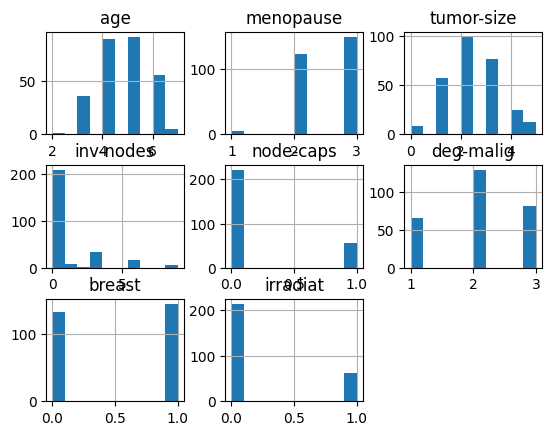

In [8]:
X.hist()

<Axes: >

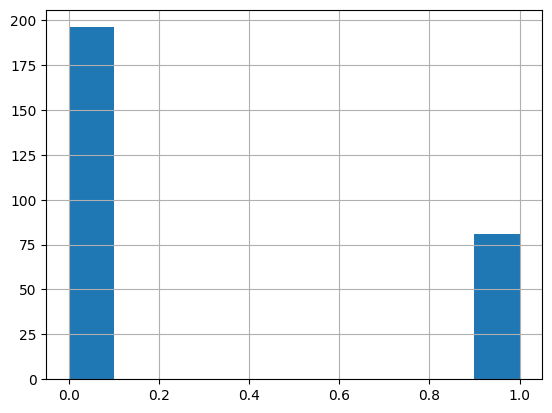

In [9]:
y.hist()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
# over sample so the minority class represents 50% of the data
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

<Axes: >

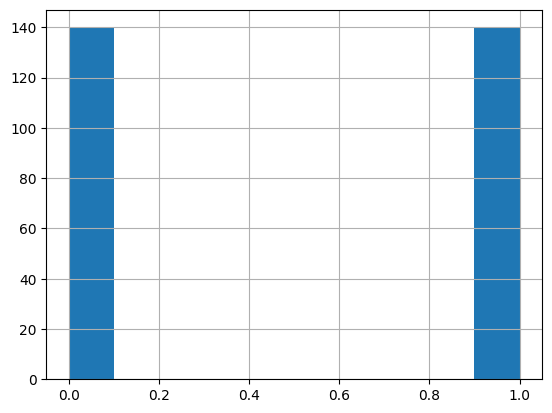

In [12]:
y_train_resampled.hist()

# Test models

We explore different models with ml flow

In [13]:
import mlflow

experiment_name = "mlflow-breast-cancer"
mlflow.set_experiment(experiment_name)
mlflow.sklearn.autolog(disable=True)

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/azureml/mlflow/_protos/aml_service_pb2.py:10: UserWarning: google.protobuf.service module is deprecated. RPC implementations should provide code generator plugins which generate code specific to the RPC implementation. service.py will be removed in Jan 2025
  from google.protobuf import service as _service
2025/01/26 18:43:05 INFO mlflow.tracking.fluent: Experiment with name 'mlflow-breast-cancer' does not exist. Creating a new experiment.


2025/01/26 18:43:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run tough_band_dzq90gsq at: https://francecentral.api.azureml.ms/mlflow/v2.0/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourceGroups/breast_cancer/providers/Microsoft.MachineLearningServices/workspaces/mlw-breast_cancer/#/experiments/0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8/runs/b21a2866-a6ea-487b-a050-5b700b611fc6.
2025/01/26 18:43:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://francecentral.api.azureml.ms/mlflow/v2.0/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourceGroups/breast_cancer/providers/Microsoft.MachineLearningServices/workspaces/mlw-breast_cancer/#/experiments/0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8.


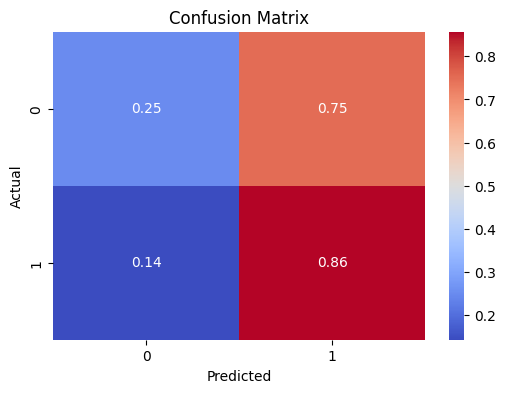

In [14]:
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

with mlflow.start_run():
    # train the model
    model = LogisticRegression(class_weight={0:1, 1:6}).fit(X_train_resampled, y_train_resampled)

    # evaluate the model
    y_pred = model.predict(X_test)

    acc = np.average(y_pred == y_test)
    auc = roc_auc_score(y_test, y_pred)

    # log metrics
    mlflow.log_param("model", "logistic regression base")
    mlflow.log_metric("Accuracy", acc)
    mlflow.log_metric("ROC_AUC", auc)

    fig = plt.figure(figsize=(6, 4)) 
    sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True, cmap="coolwarm")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    mlflow.log_figure(fig, "confusion_matrix.png")

2025/01/26 18:43:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run ivory_coconut_h6cdq3ph at: https://francecentral.api.azureml.ms/mlflow/v2.0/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourceGroups/breast_cancer/providers/Microsoft.MachineLearningServices/workspaces/mlw-breast_cancer/#/experiments/0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8/runs/51a2a625-ab93-4c6b-91c6-6078f1256e2e.
2025/01/26 18:43:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://francecentral.api.azureml.ms/mlflow/v2.0/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourceGroups/breast_cancer/providers/Microsoft.MachineLearningServices/workspaces/mlw-breast_cancer/#/experiments/0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8.


<Figure size 600x400 with 0 Axes>

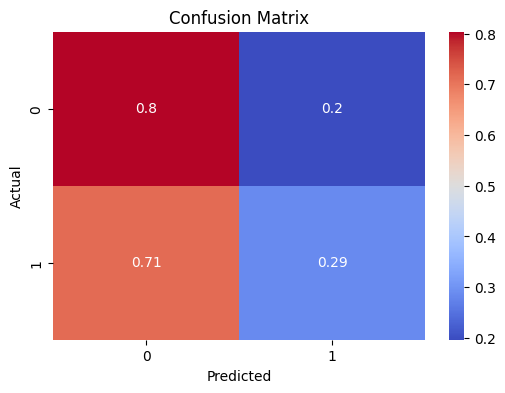

In [15]:
from xgboost import XGBClassifier

with mlflow.start_run():
    # train the model
    model = XGBClassifier().fit(X_train_resampled, y_train_resampled)

    # evaluate the model
    y_pred = model.predict(X_test)

    acc = np.average(y_pred == y_test)
    auc = roc_auc_score(y_test, y_pred)

    # log metrics
    mlflow.log_param("model", "xgboost")
    mlflow.log_metric("Accuracy", acc)
    mlflow.log_metric("ROC_AUC", auc)

    fig = plt.figure(figsize=(6, 4)) 
    sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True, cmap="coolwarm")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    mlflow.log_figure(fig, "confusion_matrix.png")

2025/01/26 18:43:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run boring_sun_34vdvhf1 at: https://francecentral.api.azureml.ms/mlflow/v2.0/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourceGroups/breast_cancer/providers/Microsoft.MachineLearningServices/workspaces/mlw-breast_cancer/#/experiments/0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8/runs/c2e06aa6-7377-4cb7-887b-d67237ae0ec9.
2025/01/26 18:43:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://francecentral.api.azureml.ms/mlflow/v2.0/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourceGroups/breast_cancer/providers/Microsoft.MachineLearningServices/workspaces/mlw-breast_cancer/#/experiments/0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8.


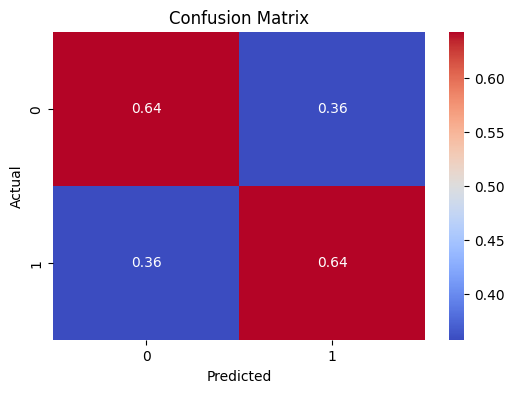

In [16]:
from sklearn.svm import SVC

with mlflow.start_run():
    # train the model
    model = SVC(class_weight={0:1, 1:3.8}).fit(X_train, y_train)

    # evaluate the model
    y_pred = model.predict(X_test)

    acc = np.average(y_pred == y_test)
    auc = roc_auc_score(y_test, y_pred)

    # log metrics
    mlflow.log_param("model", "svm")
    mlflow.log_metric("Accuracy", acc)
    mlflow.log_metric("ROC_AUC", auc)

    fig = plt.figure(figsize=(6, 4)) 
    sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True, cmap="coolwarm")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    mlflow.log_figure(fig, "confusion_matrix.png")

2025/01/26 18:43:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run gray_house_9nmjn8ws at: https://francecentral.api.azureml.ms/mlflow/v2.0/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourceGroups/breast_cancer/providers/Microsoft.MachineLearningServices/workspaces/mlw-breast_cancer/#/experiments/0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8/runs/70c73254-017e-402e-9022-7e5abad34e57.
2025/01/26 18:43:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://francecentral.api.azureml.ms/mlflow/v2.0/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourceGroups/breast_cancer/providers/Microsoft.MachineLearningServices/workspaces/mlw-breast_cancer/#/experiments/0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8.


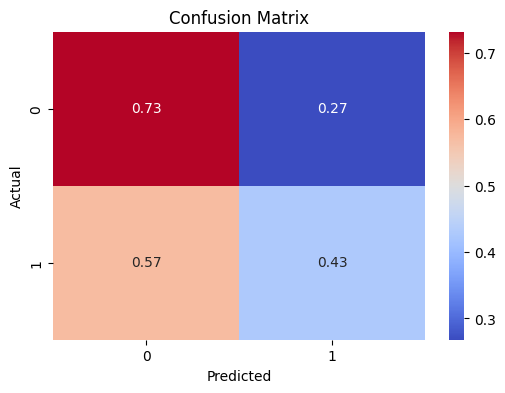

In [17]:
from sklearn.ensemble import RandomForestClassifier

with mlflow.start_run():
    # train the model
    model = RandomForestClassifier().fit(X_train_resampled, y_train_resampled)

    # evaluate the model
    y_pred = model.predict(X_test)

    acc = np.average(y_pred == y_test)
    auc = roc_auc_score(y_test, y_pred)

    # log metrics
    mlflow.log_param("model", "random forest")
    mlflow.log_metric("Accuracy", acc)
    mlflow.log_metric("ROC_AUC", auc)

    fig = plt.figure(figsize=(6, 4)) 
    sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True, cmap="coolwarm")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    mlflow.log_figure(fig, "confusion_matrix.png")

In [18]:
# Search for all runs
runs = mlflow.search_runs()

# order by ROC_AUC
runs = runs.sort_values(by=["metrics.ROC_AUC"], ascending=False)
runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.ROC_AUC,metrics.Accuracy,params.model,tags.mlflow.rootRunId,tags.mlflow.runName,tags.mlflow.user,tags.mlflow.job
2,c2e06aa6-7377-4cb7-887b-d67237ae0ec9,0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8,FINISHED,,2025-01-26 18:43:25.581000+00:00,2025-01-26 18:43:27.595000+00:00,0.642857,0.642857,svm,c2e06aa6-7377-4cb7-887b-d67237ae0ec9,boring_sun_34vdvhf1,Noam CHRETIENNOT,SVM
3,70c73254-017e-402e-9022-7e5abad34e57,0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8,FINISHED,,2025-01-26 18:43:35.754000+00:00,2025-01-26 18:43:38.032000+00:00,0.580357,0.630952,random forest,70c73254-017e-402e-9022-7e5abad34e57,gray_house_9nmjn8ws,Noam CHRETIENNOT,None
0,b21a2866-a6ea-487b-a050-5b700b611fc6,0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8,FINISHED,,2025-01-26 18:43:09.312000+00:00,2025-01-26 18:43:13.412000+00:00,0.553571,0.452381,logistic regression base,b21a2866-a6ea-487b-a050-5b700b611fc6,tough_band_dzq90gsq,Noam CHRETIENNOT,None
1,51a2a625-ab93-4c6b-91c6-6078f1256e2e,0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8,FINISHED,,2025-01-26 18:43:17.329000+00:00,2025-01-26 18:43:19.931000+00:00,0.544643,0.630952,xgboost,51a2a625-ab93-4c6b-91c6-6078f1256e2e,ivory_coconut_h6cdq3ph,Noam CHRETIENNOT,None


# Tuning Hyper-parameters

In [19]:
import optuna
import math

# fine tune the SVM model to maximize the number of true positives
def objective(trial):
    C = trial.suggest_float("C", 0.1, 10)
    gamma = trial.suggest_float("gamma", 0.1, 10)
    model = SVC(class_weight={0:1, 1:3.8}, C=C, gamma=gamma).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return math.pow(tp, 4)*tn

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-01-26 18:43:48,846] A new study created in memory with name: no-name-30a31554-b28d-4940-9d2a-f1421c75417a
[I 2025-01-26 18:43:48,856] Trial 0 finished with value: 864.0 and parameters: {'C': 9.71062717671332, 'gamma': 3.414065366296672}. Best is trial 0 with value: 864.0.
[I 2025-01-26 18:43:48,866] Trial 1 finished with value: 864.0 and parameters: {'C': 9.806162669652107, 'gamma': 4.715254924725514}. Best is trial 0 with value: 864.0.
[I 2025-01-26 18:43:48,876] Trial 2 finished with value: 864.0 and parameters: {'C': 9.237375158084069, 'gamma': 8.402970488844934}. Best is trial 0 with value: 864.0.
[I 2025-01-26 18:43:48,889] Trial 3 finished with value: 864.0 and parameters: {'C': 5.171069800009335, 'gamma': 7

In [20]:
study.best_params

{'C': 0.12116472424736549, 'gamma': 0.12495255175499978}

2025/01/26 18:44:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run amiable_nose_n64ql38q at: https://francecentral.api.azureml.ms/mlflow/v2.0/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourceGroups/breast_cancer/providers/Microsoft.MachineLearningServices/workspaces/mlw-breast_cancer/#/experiments/0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8/runs/c1ae077b-4377-4af4-99b6-f19dc3a9c823.
2025/01/26 18:44:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://francecentral.api.azureml.ms/mlflow/v2.0/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourceGroups/breast_cancer/providers/Microsoft.MachineLearningServices/workspaces/mlw-breast_cancer/#/experiments/0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8.


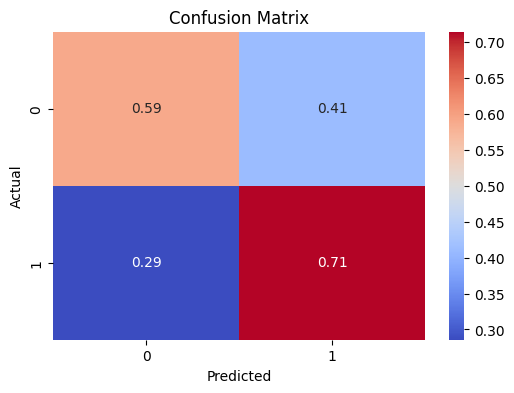

In [21]:
with mlflow.start_run():
    # train the SVM model with the best parameters (+ uses class_weight instead of resampling)
    model = SVC(class_weight={0:1, 1:3.8}, **study.best_params).fit(X_train, y_train)

    # evaluate the model
    y_pred = model.predict(X_test)

    acc = np.average(y_pred == y_test)
    auc = roc_auc_score(y_test, y_pred)

    # log metrics
    mlflow.log_param("model", "svm")
    mlflow.log_metric("Accuracy", acc)
    mlflow.log_metric("ROC_AUC", auc)

    fig = plt.figure(figsize=(6, 4)) 
    sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True, cmap="coolwarm")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    mlflow.log_figure(fig, "confusion_matrix.png")

In [22]:
# Search for all runs
runs = mlflow.search_runs()

# order by ROC_AUC
runs = runs.sort_values(by=["metrics.ROC_AUC"], ascending=False)
runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.ROC_AUC,metrics.Accuracy,params.model,params.C,params.gamma,tags.mlflow.rootRunId,tags.mlflow.runName,tags.mlflow.user,tags.mlflow.job
4,c1ae077b-4377-4af4-99b6-f19dc3a9c823,0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8,FINISHED,,2025-01-26 18:43:59.189000+00:00,2025-01-26 18:44:01.642000+00:00,0.651786,0.630952,svm_best,0.12116472424736549,0.12495255175499978,c1ae077b-4377-4af4-99b6-f19dc3a9c823,amiable_nose_n64ql38q,Noam CHRETIENNOT,None
2,c2e06aa6-7377-4cb7-887b-d67237ae0ec9,0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8,FINISHED,,2025-01-26 18:43:25.581000+00:00,2025-01-26 18:43:27.595000+00:00,0.642857,0.642857,svm,None,None,c2e06aa6-7377-4cb7-887b-d67237ae0ec9,boring_sun_34vdvhf1,Noam CHRETIENNOT,SVM
3,70c73254-017e-402e-9022-7e5abad34e57,0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8,FINISHED,,2025-01-26 18:43:35.754000+00:00,2025-01-26 18:43:38.032000+00:00,0.580357,0.630952,random forest,None,None,70c73254-017e-402e-9022-7e5abad34e57,gray_house_9nmjn8ws,Noam CHRETIENNOT,None
0,b21a2866-a6ea-487b-a050-5b700b611fc6,0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8,FINISHED,,2025-01-26 18:43:09.312000+00:00,2025-01-26 18:43:13.412000+00:00,0.553571,0.452381,logistic regression base,None,None,b21a2866-a6ea-487b-a050-5b700b611fc6,tough_band_dzq90gsq,Noam CHRETIENNOT,None
1,51a2a625-ab93-4c6b-91c6-6078f1256e2e,0e6900f7-33c0-40cf-a1fd-6ad680dbcaf8,FINISHED,,2025-01-26 18:43:17.329000+00:00,2025-01-26 18:43:19.931000+00:00,0.544643,0.630952,xgboost,None,None,51a2a625-ab93-4c6b-91c6-6078f1256e2e,ivory_coconut_h6cdq3ph,Noam CHRETIENNOT,None


# Create a pipeline to train the model

In [23]:
from azure.ai.ml import Input
from azure.ai.ml.constants import AssetTypes
from azure.ai.ml.dsl import pipeline
from azure.ai.ml import load_component

parent_dir = ""

clean_data = load_component(source=parent_dir + "envs/clean-data.yml")
train_logistic_regression = load_component(source=parent_dir + "envs/train-model.yml")

@pipeline()
def cancer_classification(pipeline_job_input):
    cleaned_data = clean_data(input_data=pipeline_job_input)
    train_model = train_logistic_regression(training_data=cleaned_data.outputs.output_data)

    # pipeline ports
    return {
        "pipeline_job_transformed_data": cleaned_data.outputs.output_data,
        "pipeline_job_trained_model": train_model.outputs.model,
    }

pipeline_job = cancer_classification(Input(type=AssetTypes.URI_FILE, path="azureml:cancer-data:1"))

In [24]:
# change the output mode
pipeline_job.outputs.pipeline_job_transformed_data.mode = "upload"
pipeline_job.outputs.pipeline_job_trained_model.mode = "upload"
# set pipeline level compute
pipeline_job.settings.default_compute = "aml-cluster"
# set pipeline level datastore
pipeline_job.settings.default_datastore = "workspaceblobstore"

# print the pipeline job again to review the changes
print(pipeline_job)

Class AutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteConditionSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseAutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class IntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ProtectionLevelSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseIntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


display_name: cancer_classification
type: pipeline
inputs:
  pipeline_job_input:
    type: uri_file
    path: azureml:cancer-data:1
outputs:
  pipeline_job_transformed_data:
    mode: upload
    type: uri_folder
  pipeline_job_trained_model:
    mode: upload
    type: mlflow_model
jobs:
  cleaned_data:
    type: command
    inputs:
      input_data:
        path: ${{parent.inputs.pipeline_job_input}}
    outputs:
      output_data: ${{parent.outputs.pipeline_job_transformed_data}}
    component:
      $schema: https://azuremlschemas.azureedge.net/latest/commandComponent.schema.json
      name: clean_data
      version: '1'
      display_name: clean training data
      type: command
      inputs:
        input_data:
          type: uri_file
      outputs:
        output_data:
          type: uri_folder
      command: python clean-data.py  --input_data ${{inputs.input_data}} --output_data
        ${{outputs.output_data}}
      environment: azureml:AzureML-sklearn-0.24-ubuntu18.04-py37-cp

In [25]:
# upload the pipeline job
pipeline_job = ml_client.jobs.create_or_update(
    pipeline_job, experiment_name="pipeline_cancer"
)

# execute the pipeline job
pipeline_job

Uploading src (0.0 MBs): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4737/4737 [00:00<00:00, 41545.56it/s]


Experiment,Name,Type,Status,Details Page
pipeline_cancer,affable_brain_vn85x8g7h1,pipeline,NotStarted,Link to Azure Machine Learning studio


# Deploy the models to endpoint

## Create the endpoint

In [27]:
from azure.ai.ml.entities import ManagedOnlineEndpoint

online_endpoint_name = "endpoint-cancer"

endpoint = ManagedOnlineEndpoint(
    name=online_endpoint_name,
    description="Online endpoint for MLflow cancer model",
    auth_mode="key",
)

In [29]:
ml_client.begin_create_or_update(endpoint).result()

ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://endpoint-cancer.francecentral.inference.ml.azure.com/score', 'openapi_uri': 'https://endpoint-cancer.francecentral.inference.ml.azure.com/swagger.json', 'name': 'endpoint-cancer', 'description': 'Online endpoint for MLflow cancer model', 'tags': {}, 'properties': {'createdBy': 'Noam CHRETIENNOT', 'createdAt': '2025-01-26T19:01:08.593274+0000', 'lastModifiedAt': '2025-01-26T19:01:08.593274+0000', 'azureml.onlineendpointid': '/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/resourcegroups/breast_cancer/providers/microsoft.machinelearningservices/workspaces/mlw-breast_cancer/onlineendpoints/endpoint-cancer', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/f95df08c-a99c-462f-b65c-fe6151267601/providers/Microsoft.MachineLearningServices/locations/francecentral/mfeOperationsStatus/oeidp:4686e71d-6618-4df2-b0cb-7d9915eed2ad:6c95e741-5904-4ffc-ad21-5369

## Choose the model

we load it from local files because of environnment bugs in Azure that were easier to modify by hand, rather than from the registry

In [ ]:
from azure.ai.ml.entities import Model
from azure.ai.ml.constants import AssetTypes

model = Model(
    path="./model",
    type=AssetTypes.MLFLOW_MODEL,
    description="svm model for cancer recurrence prediction",
)

## Create a deployment to the endpoint

it will take 100% of the traffic to the endpoint

In [101]:
from azure.ai.ml.entities import ManagedOnlineDeployment

blue_deployment = ManagedOnlineDeployment(
    name="blue",
    endpoint_name=online_endpoint_name,
    model=model,
    instance_type="Standard_F2s_v2",
    instance_count=1,
)

In [ ]:
ml_client.online_deployments.begin_create_or_update(blue_deployment).result()

In [ ]:
# blue deployment takes 100% traffic
endpoint.traffic = {"blue": 100}
ml_client.begin_create_or_update(endpoint).result()

# Test the endpoint

In [41]:
# Test the blue deployment with some sample data
response = ml_client.online_endpoints.invoke(
    endpoint_name=online_endpoint_name,
    deployment_name="blue",
    request_file="sample-data.json"
)

In [ ]:
if response[1] =='1':
    print("Recurrence")
else:
    print("No Recurrence")

In [ ]:
ml_client.online_endpoints.get(name=online_endpoint_name).scoring_uri

In [47]:
DATA_PLANE_TOKEN = ml_client.online_endpoints.get_keys(name=online_endpoint_name).primary_key
with open(".env", "w") as f:
    f.write(f"API_KEY={DATA_PLANE_TOKEN}\n")

In [ ]:
# Get the details for online endpoint
endpoint = ml_client.online_endpoints.get(name=online_endpoint_name)

# existing traffic details
print(endpoint.traffic)

# Get the scoring URI
print(endpoint.scoring_uri)

# Delete the endpoint

In [ ]:
# delete the online endpoint
# ml_client.online_endpoints.begin_delete(name=online_endpoint_name)